In [1]:
import pandas as pd
import numpy as np
import json
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('../Cole.mplstyle')

from collections import defaultdict
from sklearn import svm
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix

import lightgbm as lgb

/Users/scott/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Format keystroke df

In [2]:
all_users = np.arange(1,76)
all_sess = [0, 1, 2]
all_tasks = [0, 1]

N_char_trial = 100

if True:
    df_trials_all = pd.read_csv('../processed_data/trial_keystrokes.csv', index_col=0)
else:
    # Takes about 1 hour
    
    def find_up_time(row_i, row_key, df_ups, N_tries_max=4):
        found_match=False
        N_tries = 0
        while found_match==False and N_tries < N_tries_max:
            df_up_temp = df_ups.loc[row_i:]
            if len(df_up_temp) >= (N_tries + 1):
                idx_oi = df_up_temp.index[N_tries]
                if df_ups.loc[idx_oi, 'key'] == row_key:
                    return df_ups.loc[idx_oi, 'up_time']
                N_tries += 1
            else:
                return np.nan
        if found_match == False:
            return np.nan
    
    df_trial_list = []
    for user_i in all_users:
        print(user_i)

        for sess_i in all_sess:
            for task_i in all_tasks:
                # Determine paths to data
                file_path = '../data_raw/ub/s{:d}/baseline/{:03d}{:d}0{:d}.txt'.format(
                    sess_i, user_i, sess_i, task_i)

                df = pd.read_csv(file_path, delimiter=' ',
                         header=None, names=['key', 'event', 'time'])
                df['time'] = df['time'] - df['time'][0]
                df['time'] = df['time'].astype(float)

                # Get key down and key up times
                df_downs = df[df['event']=='KeyDown']
                df_downs.rename(columns={'time': 'down_time'}, inplace=True)
                df_downs.reset_index(inplace=True)
                df_downs.rename(columns={'index': 'old_index'}, inplace=True)

                df_ups = df[df['event']=='KeyUp']
                df_ups.rename(columns={'time': 'up_time'}, inplace=True)

                # Merge in up time
                df_downs['up_time'] = df_downs.apply(lambda row: find_up_time(row['old_index'], row['key'], df_ups), axis=1)

                # Compute dwell time
                df_downs['dwell_time'] = df_downs['up_time'] - df_downs['down_time']

                # Compute digraphs
                df_downs['dg_time'] = df_downs['down_time'].diff()

                # Compute trigraphs
                df_downs['tg_time'] = df_downs['down_time'] - np.insert(df_downs['down_time'].values[:-2], [0,0], [np.nan,np.nan])

                # Compute flight time
                df_downs['prev_up_time'] = np.insert(df_downs['up_time'].values[:-1], 0, np.nan)
                df_downs['flight_time'] = df_downs['down_time'] - df_downs['prev_up_time']

                # Compute key pair and triplet for dg/tg
                df_downs['key_prev'] = np.insert(df_downs['key'].values[:-1], 0, np.nan)
                df_downs['key_2prev'] = np.insert(df_downs['key'].values[:-2], [0,0], [np.nan, np.nan])
                df_downs['key_pair'] = df_downs['key_prev'] + '_' + df_downs['key']
                df_downs['key_trip'] = df_downs['key_2prev'] + '_' + df_downs['key_pair']

                # Remove unnecessary columns
                df_downs = df_downs[['key', 'key_pair', 'key_trip',
                                    'dg_time', 'tg_time',
                                    'flight_time', 'dwell_time']].dropna().reset_index(drop=True)

                # Split task into trials
                trial_idx_bounds = list(df_downs[::100].index)
                N_trials = len(trial_idx_bounds) - 1

                for i_trial in range(N_trials):
                    df_trial = df_downs.loc[trial_idx_bounds[i_trial]:trial_idx_bounds[i_trial+1]-1]

                    # Clean feature matrix
                    df_trial['user'] = user_i
                    df_trial['sess'] = sess_i
                    df_trial['task'] = task_i
                    df_trial['trial'] = i_trial

                    df_trial_list.append(df_trial)
    df_trials_all = pd.concat(df_trial_list)
    df_trials_all.to_csv('../processed_data/trial_keystrokes.csv')

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Compute feature matrix

### Dwell time

In [3]:
# Determine feature space for dwell time (which keys)
if True:
    dwell_use = []
    with open('../processed_data/dwell_keys_use.txt', 'r') as filehandle:  
        for line in filehandle:
            dwell_use.append(line[:-1])
else:
    # Key must occur at least X times for at least X users
    min_dwell_per_user = 5
    min_users_dwell = 50
    df_dwell_temp = df_trials_all.groupby(['key', 'user'])['dwell_time'].count().reset_index()
    df_dwell_temp['enough_N'] = df_dwell_temp['dwell_time'] >= min_dwell_per_user
    df_dwell_temp = df_dwell_temp[df_dwell_temp['enough_N']]
    dwell_counts = df_dwell_temp['key'].value_counts()
    dwell_use = list(dwell_counts[dwell_counts >= min_users_dwell].index)

    with open('../processed_data/dwell_keys_use.txt', 'w') as filehandle:  
        for listitem in dwell_use:
            filehandle.write('%s\n' % listitem)
        
# Compute dwell time features for each trial
df_dwell_feat = df_trials_all.groupby(['key', 'user', 'sess', 'task', 'trial'])['dwell_time'].median().reset_index()
df_dwell_feat = df_dwell_feat[df_dwell_feat['key'].isin(dwell_use)]
df_dwell_feat = df_dwell_feat.pivot_table(values='dwell_time', index=['user', 'sess', 'task', 'trial'], columns='key')
df_dwell_feat.rename(columns=dict(zip(df_dwell_feat.columns, ['dwell_'+k for k in df_dwell_feat.columns])), inplace=True)
df_dwell_feat.reset_index(inplace=True)

### Digraph and flight time features

In [4]:
### Sub-select digraphs
### Remove digraphs that are outliers
# These are saved for the digraphs that were present in at least 50 users

# Load digraph cutoffs
with open('../processed_data/dg_cutoffs.pkl', 'rb') as f:
    dg_cutoffs = pickle.load(f)
    
# Remove digraphs not in the cutoff dict
df_dg_temp = df_trials_all[df_trials_all['key_pair'].isin(dg_cutoffs.keys())]

# Remove outlier keystrokes
def compute_too_long(key_pair, t):
    return t > dg_cutoffs[key_pair]

df_dg_temp['cutoff'] = df_dg_temp['key_pair'].map(dg_cutoffs)
df_dg_temp['too_long'] = df_dg_temp['cutoff'] < df_dg_temp['dg_time']
df_dg_temp = df_dg_temp[~df_dg_temp['too_long']]
df_dg_temp.drop(['too_long', 'cutoff'], axis=1, inplace=True)

# Get feature matrix for digraphs and flight time
df_dg_feat = df_dg_temp.pivot_table(
    index=['user', 'sess', 'task', 'trial'],
    columns='key_pair', values='dg_time', aggfunc='median')
df_dg_feat.rename(columns=dict(zip(df_dg_feat.columns, ['digraph_'+k for k in df_dg_feat.columns])), inplace=True)
df_dg_feat.reset_index(inplace=True)

df_flight_feat = df_dg_temp.pivot_table(
    index=['user', 'sess', 'task', 'trial'],
    columns='key_pair', values='flight_time', aggfunc='median')
df_flight_feat.rename(columns=dict(zip(df_flight_feat.columns, ['flight_'+k for k in df_flight_feat.columns])), inplace=True)
df_flight_feat.reset_index(inplace=True)


/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Trigraph features

In [5]:
if True:
    trig_use = []
    with open('../processed_data/trig_keys_use.txt', 'r') as filehandle:  
        for line in filehandle:
            trig_use.append(line[:-1])
else:
    # Key must occur at least X times for at least X users
    min_trig_per_user = 10
    min_users_trig = 50
    df_trig_temp = df_trials_all.groupby(['key_trip', 'user'])['tg_time'].count().reset_index()
    df_trig_temp['enough_N'] = df_trig_temp['tg_time'] >= min_trig_per_user
    df_trig_temp = df_trig_temp[df_trig_temp['enough_N']]
    trig_counts = df_trig_temp['key_trip'].value_counts()
    trig_use = list(trig_counts[trig_counts >= min_users_trig].index)

    with open('../processed_data/trig_keys_use.txt', 'w') as filehandle:  
        for listitem in trig_use:
            filehandle.write('%s\n' % listitem)
        
# Compute trig time features for each trial
df_trig_feat = df_trials_all.groupby(['key_trip', 'user', 'sess', 'task', 'trial'])['tg_time'].median().reset_index()
df_trig_feat = df_trig_feat[df_trig_feat['key_trip'].isin(trig_use)]
df_trig_feat = df_trig_feat.pivot_table(values='tg_time', index=['user', 'sess', 'task', 'trial'], columns='key_trip')
df_trig_feat.rename(columns=dict(zip(df_trig_feat.columns, ['trigraph_'+k for k in df_trig_feat.columns])), inplace=True)
df_trig_feat.reset_index(inplace=True)

# Merge features into single feature matrix

In [6]:
df_feat = df_flight_feat.merge(df_dg_feat, on=['user', 'sess', 'task', 'trial'])
df_feat = df_feat.merge(df_trig_feat, on=['user', 'sess', 'task', 'trial'])
df_feat = df_feat.merge(df_dwell_feat, on=['user', 'sess', 'task', 'trial'])

In [7]:
# Save feat to file
df_feat.to_csv('../processed_data/lgbm_v4_feat_matrix.csv')

# LGBM for all users

In [11]:
# Parameters for training
param = {'num_leaves':4, 'max_bin': 4, 'num_trees':1000, 'objective':'binary',
         'metric': 'auc'}

# Create feature matrix
df_feat_users = df_feat.drop(['user', 'sess', 'task', 'trial'], axis=1)
col_names = list(df_feat_users.columns)
    
lgbm_eval_dict = defaultdict(list)
lgbm_pred_dict = defaultdict(list)
for user_i in all_users:
    # Make training data
    df_temp = df_feat[df_feat['sess'].isin([0,1])]
    
    train_label = np.array((df_temp['user']==user_i).values, dtype=int)
    train_data_mat = df_temp.drop(['user', 'sess','task','trial'], axis=1).as_matrix()
    train_data = lgb.Dataset(train_data_mat, label=train_label, feature_name=col_names)

    # Make test data
    df_temp = df_feat[df_feat['sess']==2]
    test_user = df_temp['user'].values
    test_sess = df_temp['sess'].values
    test_task = df_temp['task'].values
    test_trial = df_temp['trial'].values
    test_label = np.array((df_temp['user']==user_i).values, dtype=int)
    test_data_mat = df_temp.drop(['user', 'sess','task','trial'], axis=1).as_matrix()
    test_data = lgb.Dataset(test_data_mat, label=test_label, feature_name=col_names)

    # Train lgbm
    bst = lgb.train(param, train_data)
    bst.save_model('../models/v4/{:d}.txt'.format(user_i))

    # Make predictions
    ypred = bst.predict(test_data_mat)

    # Compute AUC and EER
    auc = metrics.roc_auc_score(test_label, ypred)
    fpr, tpr, thresholds = metrics.roc_curve(test_label, ypred)
    fnr = 1 - tpr
    idx_eer = np.argmin(np.abs(fpr - fnr))
    print('User {:d}, AUC = {:.3f}, EER = {:.3f}'.format(user_i, auc, fnr[idx_eer]))
    
    lgbm_eval_dict['user'].append(user_i)
    lgbm_eval_dict['auc'].append(auc)
    lgbm_eval_dict['eer'].append(fnr[idx_eer])
    
    for i_pred in range(len(ypred)):
        lgbm_pred_dict['ypred'].append(ypred[i_pred])
        lgbm_pred_dict['test_label'].append(test_label[i_pred])
        lgbm_pred_dict['user'].append(user_i)
        lgbm_pred_dict['real_user'].append(test_user[i_pred])
        lgbm_pred_dict['sess'].append(test_sess[i_pred])
        lgbm_pred_dict['task'].append(test_task[i_pred])
        lgbm_pred_dict['trial'].append(test_trial[i_pred])
        
df_all = pd.DataFrame(lgbm_eval_dict)
df_lgbm_pred = pd.DataFrame(lgbm_pred_dict)
        

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/scott/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


User 1, AUC = 0.999, EER = 0.029
User 2, AUC = 1.000, EER = 0.000
User 3, AUC = 0.996, EER = 0.049
User 4, AUC = 0.995, EER = 0.032
User 5, AUC = 0.999, EER = 0.000
User 6, AUC = 0.998, EER = 0.020
User 7, AUC = 1.000, EER = 0.000
User 8, AUC = 0.997, EER = 0.019
User 9, AUC = 0.991, EER = 0.067
User 10, AUC = 1.000, EER = 0.000
User 11, AUC = 0.997, EER = 0.017
User 12, AUC = 0.998, EER = 0.000
User 13, AUC = 1.000, EER = 0.000
User 14, AUC = 1.000, EER = 0.016
User 15, AUC = 0.993, EER = 0.035
User 16, AUC = 0.986, EER = 0.053
User 17, AUC = 1.000, EER = 0.000
User 18, AUC = 1.000, EER = 0.000
User 19, AUC = 1.000, EER = 0.000
User 20, AUC = 1.000, EER = 0.000
User 21, AUC = 0.999, EER = 0.000
User 22, AUC = 1.000, EER = 0.000
User 23, AUC = 0.988, EER = 0.069
User 24, AUC = 0.990, EER = 0.056
User 25, AUC = 0.999, EER = 0.019
User 26, AUC = 1.000, EER = 0.000
User 27, AUC = 1.000, EER = 0.000
User 28, AUC = 0.995, EER = 0.034
User 29, AUC = 0.998, EER = 0.019
User 30, AUC = 0.992, E

### Especially distinct user

Text(0, 0.5, 'Fraction of trials\n(100 characters)')

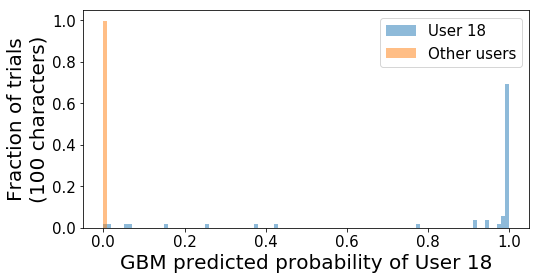

In [12]:
ypred = df_lgbm_pred.loc[df_lgbm_pred['user']==18, 'ypred']
ytrue = df_lgbm_pred.loc[df_lgbm_pred['user']==18, 'test_label']

pred_true = ypred[ytrue==1]
pred_false = ypred[ytrue==0]

plt.figure(figsize=(8,4))
plt.hist(pred_true, np.arange(0,1.01,.01), label='User 18',
         weights=[1/len(pred_true)]*len(pred_true), alpha=.5)
plt.hist(pred_false, np.arange(0,1.01,.01), label='Other users',
         weights=[1/len(pred_false)]*len(pred_false), alpha=.5);
plt.legend(fontsize=15)
plt.xlabel('GBM predicted probability of User 18')
plt.ylabel('Fraction of trials\n(100 characters)')

# Compute overall AUC and EER

In [13]:
df_all = pd.DataFrame(lgbm_eval_dict)

Text(0, 0.5, '# Users')

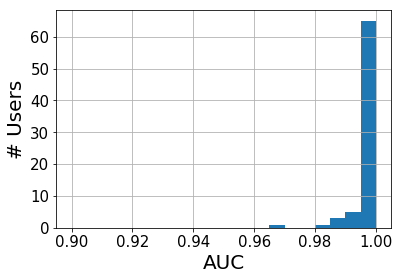

In [14]:
df_all['auc'].hist(bins=np.arange(0.9,1.005, .005))
plt.xlabel('AUC')
plt.ylabel('# Users')

Text(0, 0.5, '# Users')

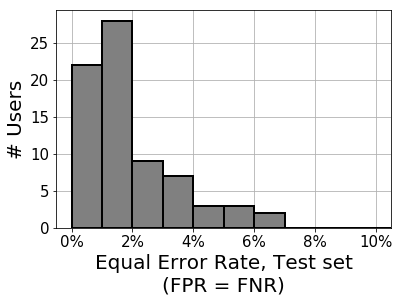

In [15]:
plt.figure(figsize=(6,4))
plt.gca().set_axisbelow(True)
df_all['eerpc'] = df_all['eer']*100
df_all['eerpc'].hist(bins=np.arange(0,12, 1), color='.5', edgecolor='k', linewidth=2)
plt.xticks(np.arange(0,11,2), ['{:d}%'.format(x) for x in np.arange(0,11,2)])
plt.xlim((-.5,10.5))
plt.xlabel('Equal Error Rate, Test set\n(FPR = FNR)')
plt.ylabel('# Users')


### Averages across data points

In [16]:
all_pred = df_lgbm_pred['ypred']
all_label = df_lgbm_pred['test_label']

# Compute AUC and EER
auc = metrics.roc_auc_score(all_label, all_pred)
fpr, tpr, thresholds_auc = metrics.roc_curve(all_label, all_pred)
fnr = 1 - tpr
idx_eer = np.argmin(np.abs(fpr - fnr))
eer_thresh = thresholds_auc[idx_eer]
print('AUC = {:.3f}, EER = {:.3f}'.format(auc, fnr[idx_eer]))
print('threshold = {:.5f}'.format(thresholds_auc[idx_eer]))

AUC = 0.998, EER = 0.024
threshold = 0.00011


(-0.02, 1.02)

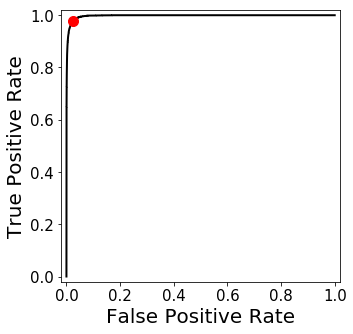

In [17]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, 'k')
plt.plot(fpr[idx_eer], tpr[idx_eer], 'r.', ms=20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(-.02, 1.02)
plt.ylim(-.02, 1.02)

### Averages across users

In [18]:
print('Mean AUC = {:.3f}, EER = {:.3f}'.format(df_all['auc'].mean(), df_all['eer'].mean()))
print('Median AUC = {:.3f}, EER = {:.3f}'.format(df_all['auc'].median(), df_all['eer'].median()))

Mean AUC = 0.997, EER = 0.020
Median AUC = 0.998, EER = 0.018


# Probability calibration and threshold from Validation
* Obtained from validation notebook

In [19]:
# Need to recompute probability calibration
old_pred_samp_valid = np.array([1.89497064e-05, 1.50911086e-03, 3.38746918e-03, 6.98252100e-03,
       1.51188199e-02, 3.30878871e-02, 7.00502972e-02, 1.52832984e-01,
       3.32861811e-01, 9.37748610e-01, 1.00000000e+00])
new_pred_samp_valid = np.array([0.06924164, 0.92424242, 0.9047619 , 0.94186047, 0.97142857,
       0.98305085, 0.99342105, 0.9875    , 1.        , 0.99816244,
       1.        ])
valid_thresh = 0.07012

df_lgbm_pred['ypred_valid'] = np.interp(df_lgbm_pred['ypred'].values,
                            old_pred_samp_valid, new_pred_samp_valid)
df_lgbm_pred['ypredclass_valid'] = df_lgbm_pred['ypred_valid'] > valid_thresh


In [20]:
all_pred_valid = df_lgbm_pred['ypred_valid']
all_predclass_valid = df_lgbm_pred['ypredclass_valid']

### Get valid eer thresh

In [21]:
# Compute AUC and EER
auc = metrics.roc_auc_score(all_label, all_pred_valid)
fpr, tpr, thresholds_auc = metrics.roc_curve(all_label, all_pred_valid)
fnr = 1 - tpr
idx_eer = np.argmin(np.abs(fpr - fnr))
eer_thresh_valid = thresholds_auc[idx_eer]
print('AUC = {:.3f}, EER = {:.3f}'.format(auc, fnr[idx_eer]))
print('threshold = {:.5f}'.format(eer_thresh_valid))

AUC = 0.993, EER = 0.024
threshold = 0.12069


In [22]:
# Save to file
df_lgbm_pred.to_csv('../processed_data/lgbm_v4_predictions.csv')

# Feature importance

In [23]:
feature_import_dict = {}
feature_import_dict['feature'] = col_names
importance_type = 'split' # or 'gain' about the same
for user_i in all_users:
    bst = lgb.Booster(model_file='../models/v4/{:d}.txt'.format(user_i))
    feature_import_dict[user_i] = bst.feature_importance(importance_type=importance_type)
df_feat_import = pd.DataFrame(feature_import_dict).set_index('feature').T

In [24]:
avg_feat_imp = df_feat_import.mean().sort_values(ascending=False)
df_feat_imp = pd.DataFrame(avg_feat_imp).rename(columns={0:'importance (%)'})
df_feat_imp['importance (%)'] = df_feat_imp['importance (%)'] / (np.sum(df_feat_imp['importance (%)']/100))

In [25]:
styles = [
    dict(selector='th', props=[('font-size', '200%'),
                               ('text-align', 'center')]),
    dict(selector='td', props=[('font-size', '200%'),
                               ('text-align', 'center')])
]
df_feat_imp.head(10).round(1).style.set_table_styles(styles)

,importance (%)
feature,
dwell_LShiftKey,1.6
dwell_Space,1.4
dwell_RShiftKey,1.1
flight_I_N,1
flight_O_U,1
dwell_A,0.9
flight_T_H,0.9
dwell_Back,0.7
digraph_O_U,0.7


In [26]:
df_feat_imp.tail(10).round(4).style.set_table_styles(styles)

,importance (%)
feature,
flight_R_D,0.0014
flight_Space_U,0.0009
flight_Z_E,0.0005
digraph_B_S,0.0005
flight_B_S,0.0005
digraph_L_P,0
flight_Y_S,0
digraph_S_N,0
flight_V_O,0
